# Preprocessing Audio

### Importing Libraries

In [1]:
# Initializing Spark
import findspark
findspark.init()

# Importing PySpark related
from pyspark import SparkContext
from pyspark.sql import SparkSession
import collections

In [2]:
# Importing other packages
import numpy as np
import librosa
import librosa.display
import io
import os
import soundfile as sf
from IPython import display
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

### Initializing Spark

In [3]:
# Creating Spark Session
spark = SparkSession.builder \
    .master('local') \
    .appName('AudioAttempt') \
    .config('spark.executor.memory', '8gb') \
    .getOrCreate()

In [4]:
# Creating Spark context
context = spark.sparkContext

### Loading Data

In [5]:
# Loading audio data into cluster memory as binary data
paths = 'data/local/bird,data/local/bed,data/local/cat'

baseAudio = context.binaryFiles(paths)

### Defining Transformer Functions

In [6]:
# Function to carve out class from file path
def carveClassName(x):
    return x.split('/')[-2]

In [7]:
# Function to convert audio stored as binary in-memory to numerical data
def binaryToNumerical(x):
    return sf.read(io.BytesIO(x))[0]

In [8]:
# Function to perform fourier transformation on audio snippets to get energy in different frequency ranges
def fourierTransformation(x):
    audio = librosa.amplitude_to_db(abs(librosa.stft(x, hop_length=321)))
    
    # Padding audio up to one second length if it is shorter
    if audio.shape[1] < 50:
        filler = np.zeros((1025, 50 - audio.shape[1]))
        audio = np.concatenate((audio, filler), axis = 1)
        
    return audio

### Applying Transformer Functions

In [9]:
convertedAndLabeledAudio = baseAudio.map(lambda x: [carveClassName(x[0]), binaryToNumerical(x[1])])

In [10]:
transformedAudio = convertedAndLabeledAudio.map(lambda x: [x[0], fourierTransformation(x[1])])

In [11]:
processed = np.array(transformedAudio.collect())

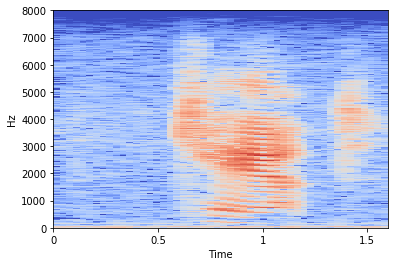

In [12]:
librosa.display.specshow(processed[400][1], sr=16000, x_axis='time', y_axis='hz')

# Building Tensorflow Model

### Importing Libraries

In [13]:
# Importing TensorFlow
import tensorflow as tf
# import tensorflowonspark as tfos
# from tensorflowonspark import TFCluster # Needs package 'packaging' to be installed manually to run properly

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, DenseFeatures
from tensorflow import feature_column
import tensorflow.keras as keras

### Setting Up Model

In [47]:
# Setting up distributed strategy for model
strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

In [48]:
with strategy.scope():
    # Initiating model
    model = Sequential()

    # Building model structure
    model.add(Input(shape=(1025, 50, 1)))
    model.add(Conv2D(64, kernel_size=[5,5], padding='same', activation='relu', data_format='channels_last', input_shape=processed.shape))
    model.add(MaxPool2D(pool_size=[5,5], data_format='channels_last'))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(32))
    # model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compiling model
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [50]:
# Displaying model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 1025, 50, 64)      1664      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 205, 10, 64)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 131200)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 131200)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4198432   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 4,200,129
Trainable params: 4,200,129
Non-trainable params: 0
____________________________________________

### Preparing Data For Model

In [36]:
# Splitting into X and y
X = np.array([i[1] for i in processed])
y = np.array([i[0] for i in processed])

In [37]:
# Encoding labels
_, y = np.unique(y, return_inverse=True)

In [38]:
# Adjusting data shape
X = X.reshape(-1, 1025, 50, 1)

In [39]:
X.shape

(600, 1025, 50, 1)

In [40]:
# Shuffling X and y in unison
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state = 0)

In [41]:
y.shape

(600,)

### Testing If GPU In Use

In [49]:
tf.test.is_built_with_cuda()

True

In [43]:
tf.test.is_gpu_available()

True

In [44]:
tf.test.gpu_device_name()

'/device:GPU:0'

### Training Model

In [45]:
# Setting up Tensorboard
import datetime

logDir = os.path.join("Logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tbCallback = tf.keras.callbacks.TensorBoard(log_dir=logDir, histogram_freq=1, profile_batch=10000000)

In [51]:
# Fitting model
model.fit(X, y, batch_size=4, epochs=10, callbacks=[tbCallback])

Train on 600 samples
Epoch 1/10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
600/600 [==============================] - 3s 5ms/sample - loss: -202.2339 - accuracy: 0.3400
Epoch 2/10
600/600 [==============================] - 2s 4ms/sample - loss: -7456.7821 - accuracy: 0.3467
Epoch 3/10
600/600 [==============================] - 2s 4ms/sample - loss: -37493.6879 - accuracy: 0.3367
Epoch 4/10
600/600 [==============================] - 2s 4ms/sample - loss: -139500.8358 - accuracy: 